In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from beamconv import Beam

In [2]:
def penalty(hwp_data, hwp_model):
    '''
    Calculate Frobenius norm of inner 2x2 part of
    data - model.
        
    Parameters
    ----------
    hwp_data : (4, 4) array
        HWP matrix.
    hwp_ideal : (4, 4) array
        Ideal HWP Mueller matrix.
        
    Returns
    -------
    penalty : float
    '''

    penalty = np.sqrt(np.sum((hwp_data - hwp_model)[1:3,1:3] ** 2))
        
    return penalty

In [8]:
nu = np.linspace(135, 165, 7)
beam = Beam()
beam.el = 0
ahwp_name = '3AR3BRstd'

hwp_matrices = np.zeros((nu.size, 4, 4))

for fidx, freq in enumerate(nu):
    beam.sensitive_freq = freq
    beam.set_hwp_mueller(model_name=ahwp_name)
    hwp_matrices[fidx,...] = beam.hwp_mueller

In [5]:
def get_rotated_mueller_matrix(mat, angle):
    '''
    Return rotated Mueller matrix.
    
    Parameters
    ----------
    mat : (4, 4) or (N, 4, 4) array
    angle : float
        Angle in radians.
        
    Returns
    -------
    mat_rot : (4, 4) array    
    '''

    mrot = np.array([[1., 0., 0., 0.], 
              [0., np.cos(2 * angle), np.sin(2 * angle), 0.],
              [0., -np.sin(2 * angle), np.cos(2 * angle), 0.],
              [0. ,0. ,0. , 1.]])

    return mrot.T @ mat @ mrot

In [6]:
def modBB(nu, beta=1.59):
    hkb = 4.799e-11
    T = 15.9
    wien_peak = 9.3475e11
    wien_modi = (wien_peak**beta)*np.exp(-hkb*wien_peak/T) 
    return ((nu*1e9)**beta)*np.exp(-hkb*nu*1e9/T)/wien_modi

# integrate matrix
M_integ_dust = np.zeros((4,4))
M_integ_cmb = np.zeros((4,4))
for i in range (4):
    for j in range (4):
        M_integ_dust[i,j] = simps(hwp_matrices[:,i,j] * modBB(nu), x=nu) / simps(modBB(nu), x=nu)
        M_integ_cmb[i,j] = np.average(hwp_matrices[:,i,j], axis = 0)

In [7]:
ideal = np.eye(4)
ideal[2,2] = -1
ideal[3,3] = -1

First we optimize the angle offset we need to apply to the ideal HWP to match the nonideal one.

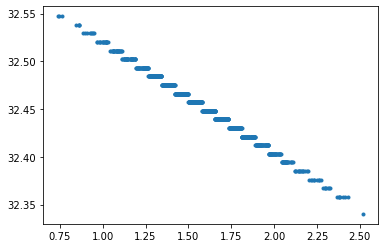

In [9]:
#Beta distribution for the d3 model
betas = np.random.normal(loc=1.59, scale=0.3, size=1000)
minang = np.zeros_like(betas)
for k, beta in enumerate(betas):
    M_integ_dust = np.zeros((4,4))
    M_integ_cmb = np.zeros((4,4))
    for i in range (4):
        for j in range (4):
            M_integ_dust[i,j] = simps(hwp_matrices[:,i,j] * modBB(nu, beta), x=nu) / simps(modBB(nu, beta), x=nu)
            M_integ_cmb[i,j] = np.average(hwp_matrices[:,i,j], axis = 0)
    alphas = np.linspace(0, 90, 10)
    offsets = np.linspace(0, 90, 10000)
    penalties_dust = np.zeros_like(offsets)
    penalties_cmb = np.zeros_like(offsets)
    for oidx, offset in enumerate(offsets):
        m_data_dust = get_rotated_mueller_matrix(M_integ_dust, np.radians(0))
        m_model = get_rotated_mueller_matrix(ideal, np.radians(offset))
        penalties_dust[oidx] = penalty(m_data_dust, m_model)
    minang[k] = offsets[np.argmin(penalties_dust)]
    
plt.plot(betas, minang, '.')

32.45189918991899


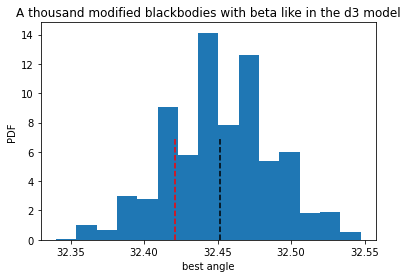

In [10]:
plt.figure(1)
plt.hist(minang, bins=15, density=True)
plt.vlines(32.4212, ymin=0, ymax=7, colors ='r', ls='--')
plt.vlines(np.average(minang), ymin=0, ymax=7, colors ='k', ls = '--')
plt.xlabel('best angle')
plt.ylabel('PDF')
plt.title('A thousand modified blackbodies with beta like in the d3 model')
print(np.average(minang))


In [11]:
alphas = np.linspace(0, 90, 10)
offsets = np.linspace(0, 90, 10000)
penalties_dust = np.zeros_like(offsets)
penalties_cmb = np.zeros_like(offsets)
for oidx, offset in enumerate(offsets):
    m_data_dust = get_rotated_mueller_matrix(M_integ_dust, np.radians(0))
    m_data_cmb = get_rotated_mueller_matrix(M_integ_cmb, np.radians(0))
    m_model = get_rotated_mueller_matrix(ideal, np.radians(offset))
    penalties_dust[oidx] = penalty(m_data_dust, m_model)
    penalties_cmb[oidx] = penalty(m_data_cmb, m_model)

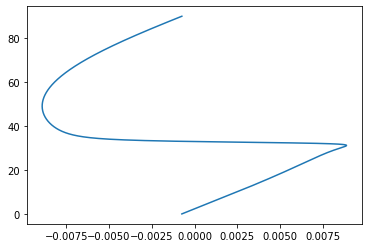

In [12]:
plt.plot(penalties_cmb - penalties_dust, offsets)

In [13]:
best_offset = np.radians(offsets[np.argmin(penalties_dust)])
print("Dust optimal:", np.degrees(best_offset))
best_offset = np.radians(offsets[np.argmin(penalties_cmb)])
print("CMB optimal:", np.degrees(best_offset))

Dust optimal: 32.430243024302435
CMB optimal: 32.511251125112516


In [ ]:
thetas = np.linspace(0,10,11)

for th in thetas:
    offsets = np.linspace(0, 90, 10000)
    penalties = np.zeros_like(offsets)
    nu = np.linspace(80, 110, 7)
    beam = Beam()
    beam.el = th
    ahwp_name = '3BR'

    hwp_matrices = np.zeros((nu.size, 4, 4))

    for fidx, freq in enumerate(nu):
        beam.sensitive_freq = freq
        beam.set_hwp_mueller(model_name=ahwp_name)
        hwp_matrices[fidx,...] = beam.hwp_mueller
    M_integ = np.zeros((4,4))
    for i in range (4):
        for j in range (4):
            M_integ[i,j] = simps(hwp_matrices[:,i,j]* modBB(nu), x=nu) / simps(modBB(nu), x=nu)
    for oidx, offset in enumerate(offsets):
        m_data = get_rotated_mueller_matrix(M_integ, np.radians(0))
        m_model = get_rotated_mueller_matrix(ideal, np.radians(offset))
        penalties[oidx] = penalty(m_data, m_model)
    plt.plot(offsets, penalties, ':')
    best_offset = np.radians(offsets[np.argmin(penalties)])
    print('theta={:d} varphi={:f}'.format(int(th), np.degrees(best_offset)))

In [ ]:
alphas = np.linspace(0, 180, 1800)
nonideal_arr = np.zeros((alphas.size,) + (4, 4))
ideal_arr = np.zeros_like(nonideal_arr)

for aidx, alpha in enumerate(alphas):
    nonideal_arr[aidx] = get_rotated_mueller_matrix(M_integ, np.radians(alpha))
    ideal_arr[aidx] = get_rotated_mueller_matrix(ideal, np.radians(alpha) + best_offset)

f4, axs4 = plt.subplots(4, 4, figsize=(15, 9), sharey=False, sharex=True)
plt.rcParams['axes.labelsize'] = 13
tit = (r'$_{I}$',r'$_{Q}$', r'$_{U}$',r'$_{V}$')
for i in range (4):
    for j in range(4):
        axs4[i,j].plot(alphas, nonideal_arr[:,i,j], linestyle = '-', alpha=0.5, label='integrated BR3')
        
        axs4[i,j].plot(alphas, ideal_arr[:,i,j], linestyle = '-.', alpha=0.5, label='Ideal')
        axs4[i,j].set_title(r'$M$'+tit[i]+tit[j], fontsize= '12')

f4.subplots_adjust(right=0.875)
f4.text(0.5, 0.02, r'$offset(deg)$', ha='center',fontweight="bold", fontsize='13')
f4.text(0.055, 0.5,'Value 'r'$M_{ij}$' , va='center', rotation='vertical',fontweight="bold", fontsize='13')
plt.legend(bbox_to_anchor=(1.04,.0), loc="lower left", borderaxespad=0.1, prop={'size': 12}, facecolor='white',  
    edgecolor='black', framealpha=1, ncol=1)
plt.show()

Now we optimize the angle offset we need to apply to the nonideal HWP to match the ideal one.

In [ ]:
alphas = np.linspace(0, 90, 10)
offsets = np.linspace(0, 90, 10000)
penalties = np.zeros_like(offsets)

for oidx, offset in enumerate(offsets):
    m_data = get_rotated_mueller_matrix(M_integ, np.radians(offset))
    m_model = get_rotated_mueller_matrix(ideal, np.radians(0))
    penalties[oidx] = penalty(m_data, m_model)

In [ ]:
plt.plot(offsets, penalties)

In [ ]:
best_offset = np.radians(offsets[np.argmin(penalties)])
print(np.degrees(best_offset))

In [ ]:
alphas = np.linspace(0, 180, 1800)
nonideal_arr = np.zeros((alphas.size,) + (4, 4))
ideal_arr = np.zeros_like(nonideal_arr)

for aidx, alpha in enumerate(alphas):
    nonideal_arr[aidx] = get_rotated_mueller_matrix(M_integ, np.radians(alpha) + best_offset)
    ideal_arr[aidx] = get_rotated_mueller_matrix(ideal, np.radians(alpha))

f4, axs4 = plt.subplots(4, 4, figsize=(15, 9), sharey=False, sharex=True)
plt.rcParams['axes.labelsize'] = 13
tit = (r'$_{I}$',r'$_{Q}$', r'$_{U}$',r'$_{V}$')
for i in range (4):
    for j in range(4):
        axs4[i,j].plot(alphas, nonideal_arr[:,i,j], linestyle = '-', alpha=0.5, label='integrated BR3')
        
        axs4[i,j].plot(alphas, ideal_arr[:,i,j], linestyle = '-.', alpha=0.5, label='Ideal')
        axs4[i,j].set_title(r'$M$'+tit[i]+tit[j], fontsize= '12')

f4.subplots_adjust(right=0.875)
f4.text(0.5, 0.02, r'$offset(deg)$', ha='center',fontweight="bold", fontsize='13')
f4.text(0.055, 0.5,'Value 'r'$M_{ij}$' , va='center', rotation='vertical',fontweight="bold", fontsize='13')
plt.legend(bbox_to_anchor=(1.04,.0), loc="lower left", borderaxespad=0.1, prop={'size': 12}, facecolor='white',  
    edgecolor='black', framealpha=1, ncol=1)
plt.show()